In [2400]:
import networkx as nx
import requests
import json
import matplotlib.pyplot as plt


#['app2', 'app5']
#5afdb8cf93beb10025c13f4f
url = 'localhost:5010'
entries = ['app5', 'app6']
rolesa = '593f49be42d3ed97390f25a7'

In [2401]:
pipeline = [
    {'$match': {'name': {'$in': entries}, 'roles._id': rolesa}},
    {
        '$graphLookup': {
            'from': 'applications',
            'startWith': '$deps._id',
            'connectFromField': 'deps._id',
            'connectToField': '_id',
            'as': 'nodes',
            'maxDepth': 10,
            'depthField': 'steps'
        }
    },
    {'$project': {'name': 1, 'deps': 1, 'deps': 1, 'nodes.name': 1, 'nodes.steps': 1, 'nodes.deps': 1}}
];

jpipeline = json.dumps(pipeline)

data = requests.post('http://%s/aggregate' % url, json={'entity': 'applications', 'pipeline': jpipeline})
data = data.json()
print(data)

{'items': [{'_id': '5b3ec47706f9e50f2f36acc8', 'name': 'app5', 'deps': [{'endpoint': 'rest', '_id': '5b3ec3dc06f9e50f2f36acc6', 'family': 'Application', 'name': 'sroot'}, {'endpoint': 'rest', '_id': '5b340835b3bad96ea3a82eff', 'family': 'Loadbalance', 'name': 'lb 2'}, {'endpoint': 'rest', '_id': '5b41116206f9e50f2f36accf', 'family': 'Broker', 'name': 'brokercd'}], 'nodes': [{'name': 'ci114', 'steps': 1}, {'name': 'ci113', 'steps': 1}, {'name': 'ci112', 'steps': 1}, {'name': 'ci11', 'steps': 1}, {'name': 'appLb2', 'steps': 1}, {'name': 'appLb1', 'steps': 1}, {'name': 'app1', 'deps': [{'endpoint': 'rest', '_id': '5b2c6ead61de951c159d44d0', 'family': 'Database', 'name': 'mysql1'}], 'steps': 1}, {'name': 'mysql1', 'steps': 2}, {'name': 'brokercd', 'deps': [{'endpoint': 'amqp', '_id': '5b41115706f9e50f2f36accd', 'family': 'CI/CD', 'name': 'ci114'}, {'endpoint': 'amqp', '_id': '5b41114f06f9e50f2f36accb', 'family': 'CI/CD', 'name': 'ci112'}, {'endpoint': 'amqp', '_id': '5b41115306f9e50f2f36ac

In [2402]:

class BaseNetwork(object):
    def __init__(self, G=nx.DiGraph):
        self.graph = G()
        self.clear_duplicate()

    def create_edge(self, item):
        if 'deps' in item:
            for dps in item['deps']:
                w = item.get('steps', -1)
                self.graph.add_edge(item['name'], dps['name'], weight=w+1)

    def create_node(self, node_id, item, root = False):
        if node_id not in self.duplicate:
            self.graph.add_node(node_id, uid=item.get('_id'), label=item.get('name'), root=root, object=item)
            self.duplicate.append(node_id)

    def make(self, data, i=0):
        for item in data:
            self.create_node(item['name'], item, i is 0)
            
            if 'nodes' in item and len(item['nodes']) > 0:
                self.make(item['nodes'], i+1)
                
            self.create_edge(item)
            
        self.clear_duplicate()   
        return self

    def get_graph(self):
        return self.graph

    def clear_duplicate(self):
        self.duplicate = []
    
class DrawNetwork(object):

    def __init__(self, G):
        self.graph = G
        
    def get_cardials(self):
        return nx.circular_layout(self.graph)
    
    
    def save_svg(self, options, labels):
        #plt.figure(figsize=(4, 4))
        pos = self.get_cardials()

        nx.draw(self.graph, pos, **options)

        labels = nx.get_edge_attributes(self.graph,'weight')
        nx.draw_networkx_edge_labels(self.graph,pos,edge_labels=labels)

        plt.axis('equal')
        plt.show()
        return pos

network = BaseNetwork()
network.make(data.get('items')).get_graph()

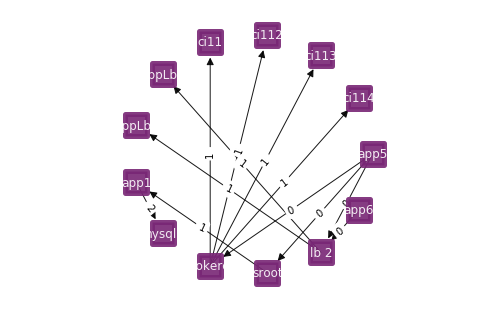

{'app5': array([ 1.00000000e+00, -2.29248627e-09]), 'ci114': array([0.88545603, 0.46472315]), 'ci113': array([0.56806476, 0.82298384]), 'ci112': array([0.12053671, 0.99270883]), 'ci11': array([-0.3546048 ,  0.93501625]), 'appLb2': array([-0.74851073,  0.66312263]), 'appLb1': array([-0.97094179,  0.23931566]), 'app1': array([-0.97094179, -0.23931561]), 'mysql1': array([-0.74851079, -0.66312258]), 'brokercd': array([-0.35460498, -0.93501619]), 'sroot': array([ 0.12053677, -0.99270884]), 'lb 2': array([ 0.56806458, -0.82298396]), 'app6': array([ 0.88545603, -0.46472319])}


In [2403]:
options = {
    'with_labels': True,
    'arrowsize': 15,
    'node_shape': 's',
    'node_size': 500,
    'node_color': '#782675',
    'font_color': 'white',
    'alpha': 0.9,
    'linewidths': 5
}

labels = {
    'font_weight': 'bold'
}

draw = DrawNetwork(network.graph)
draw.save_svg(options, labels)

print(draw.get_cardials())

In [2404]:
G=network.graph
#nei = list(network.graph.neighbors('app1'))
#print(nei)

#network.graph.degree['app1']

#G.out_degree('app1')
#G.in_degree('app1')

In [2405]:

from svgwrite import Drawing
from operator import itemgetter
from IPython.display import SVG, display
from networkx.classes.reportviews import OutEdgeView

In [2406]:
pagerank = nx.pagerank(G, alpha=0.9)
print(pagerank)

density = nx.density(G)
print(density)

hist = nx.degree_histogram(G)

{'app5': 0.05743832394895711, 'ci114': 0.07036191613491995, 'ci113': 0.07036191613491995, 'ci112': 0.07036191613491995, 'ci11': 0.07036191613491995, 'appLb2': 0.08328550832088279, 'appLb1': 0.08328550832088279, 'app1': 0.10913269269280848, 'mysql1': 0.15565700638096114, 'brokercd': 0.05743832394895711, 'sroot': 0.05743832394895711, 'lb 2': 0.05743832394895711, 'app6': 0.05743832394895711}
0.07692307692307693


In [2407]:
import collections

class Histogram(object):
    def __init__(self):
        self._hist = None
        
    def set_collections(self, data):
        self._hist = collections.Counter(data)
        return self
        
    def get_counter(self):
        return dict(self._hist)
    
    def max_columm(self):
        if self._hist is not None:
            return self._hist.most_common(1)[0]
    
    def max_value(self):
        n = self.max_columm()
        if n:
            return n[1]    
    
class GridHistogram(Histogram):
    def __init__(self, grid):
        super().__init__()
        self.grid = grid
        self.make()
    
    def make(self):
        clear = {}
        
        for key, value in self.grid.items():
            clear[key] = len(value)
   
        self.set_collections(clear)
        
class GraphHistogram(Histogram):
    
    def __init__(self, G):
        super().__init__()
        self.graph = G
        self.make()
    
    def find_weight(self, item, weight=0):
        root = self.graph.nodes[item].get('root')
        
        if not root:
            pred = self.graph.in_edges(item, data=True)

            if pred and len(list(pred)) > 0:
                weight = max([it[2].get('weight') for it in pred]) + 1
        
        return weight

    def make(self):
        nodes = self.graph.nodes()
        weights = []
        
        for node in nodes:
            w = self.find_weight(node)
            weights.append(w)
            self.graph.nodes[node]['weight'] = w
    
        self.set_collections(weights)
 
        
GraphHistogram(G).get_counter()

{0: 2, 2: 7, 3: 1, 1: 3}

In [2408]:

class DefsSVG(object):
    
    def __init__(self, draw):
        self.dwg = draw

    def app(self, pos, title, size=(20,20), unit="px"):
        opts = {
            'size': ("%s%s"%(size[0], unit), "%s%s"%(size[1], unit)),
            'stroke_width': "1",
            'stroke': "black",
            'fill': "rgb(255,255,0)"
        }
        
        self.add(self.dwg.rect(insert = pos, **opts))
        self.add(self.dwg.text(title, insert=(pos[0], pos[1]+10), fill='red'))
    
    def line(self, cx, cy):
        opts = {
            'stroke_width': "1",
            'stroke': "black",
            'fill': "rgb(0,0,0)"
        }
        
        self.add(self.dwg.line(start=cx, end=cy, **opts))
    
    def add(self, svg):
        self.dwg.add(svg)
        
class DrawArea(object):
    def __init__(self, off, size, hist, nmax):
        self._off = off
        self._size = size
        self._hist = hist
        self._nmax = nmax
        
    def cal_area(self, n, pointer):
        return (n * self._size[pointer]) + (n * self._off[pointer])
    
    def area(self):
        area_y = self.cal_area(self._nmax, 1)
        area_x = self.cal_area(max(self._hist, key=int) + 1, 1)
        return (area_x, area_y)
    
class DrawSVG(object):
    def __init__(self, hist, nmax, darea=DrawArea, draw=Drawing, defs=DefsSVG):
        self._off = (40, 40)
        self._size = (20, 20)
    
        self._hist = hist
        self._nmax = nmax
        
        self._area = darea(self._off, self._size, hist, nmax).area()
        self.dwg = Drawing('test.svg', size=self._area)
        self._grid_defs = defs(self.dwg)
    
    def draw_app(self, pos, w, label):
        pos = self.cal_off(pos, w)
        self._grid_defs.app(pos, label, self._size)
    
    def draw_connect(self, pos1, pos2, w1, w2):
        pos1 = self.cal_pos_line(pos1, w1, self._size[0])
        pos2 = self.cal_pos_line(pos2, w2)
        
        self._grid_defs.line(pos1, pos2)
   
    def cal_off(self, pos, w):
        x = self.cal_offx(pos[0], w)
        y = self.cal_offy(pos[1], w)
        
        return (x, y)
        
    def cal_offy(self, y, w):  
        off = 0
        #if self._hist[w] < self._nmax:
        #    off = (self._nmax - self._hist[w]) / 2
        #    off = off * (self._off[1] + self._size[1])
        
        return (y * self._off[1]) + (y * self._size[1]) + off 
    
    def cal_offx(self, x, w):
        return (x * self._off[0]) + (x * self._size[0])
    
    def cal_pos_line(self, pos, w, suff_x=0):
        apos = self.cal_off(pos, w)
        y = apos[1] + (self._size[1]/2)
        x = apos[0] + suff_x
        
        return (x, y)
    
    def save(self):
        self.dwg.save()
        
class DrawLayout(object):
    def __init__(self, grid, gridhist=GridHistogram, draw=DrawSVG):
        
        self._grid = grid
        
        GridHistogram = gridhist(self._grid.get_grid())
        self._nmax = GridHistogram.max_value()
        self._hist = GridHistogram.get_counter()
        
        self.drawer = draw(self._hist, self._nmax)

    def draw_nodes(self):
        data = self._grid.get_grid()
        for col_k, columm in data.items():
            for line_k, label in columm.items():
                self.drawer.draw_app((col_k, line_k), col_k, label)
        
        return self
    
    def draw_connections(self, edges):
        for edge in edges:
            pos = []
            w = []
            
            for i in range(2):
                ipos = self._grid.get_pos(edge[i])
                pos.append(ipos)
                w.append(ipos[0])

            self.drawer.draw_connect(*pos, *w)
            
        return self 
    
    def save(self):
        self.drawer.save()

In [2409]:
class GridOrchestrator(object):
    
    def __init__(self, G, finderpos=PositionFinder):
        self._graph = G
        
        FinderPosition = finderpos(G) #hooked system, which position
        self._grid = GridMap(FinderPosition) # Control each position
        
        
    def create(self, entries):
        self._recursive_draw(entries)
    
    def get_grid(self):
        return self._grid
    
    def _recursive_draw(self, app, i=0):
        if i>30:
            return
        
        for item in app:
            if self._grid.get_pos(item) is None:
                node = self._graph.nodes[item]
                self._grid.add_pos_grid(node)
                
                succ = self._graph.successors(item)
                self._recursive_draw(succ, i+1)

In [2410]:
class GPos(object):
    
    def __init__(self):
        self._dummies = []
        self._positions = []
        self._swaps = []
        self._size = 1
        
    def append_dummy(self, dummy):
        self._dummies.append(dummy)
        
    def append_swap(self, swap):
        self._swaps.append(swap)
    
    def set_position(self, pos):
        self._positions = pos
    
    def set_size(self, size):
        self._size = size
        
    def inc_size(self, inc=1):
        self._size += inc
    
    def get_size(self):
        return self.get_positions()[3]
    
    def get_x(self):
        return self.get_positions()[0]
    
    def get_y(self):
        return self.get_positions()[1]
    
    def get_positions(self):
        return self._get('positions')
    
    def get_dummies(self):
        return self._get('dummies')
    
    def get_swap(self):
        return self._get('swap')
    
    def _get(self, item):
        prop = '_'+item
        data = getattr(self, prop)
        return data
    
class GridMap(object):
    def __init__(self, finder):
        self.clean()
        
        self.finder = finder
        self.finder.set_grid(self.grid)
    
    def add_pos_grid(self, node):
        gpos = self.finder.give_pos(node)
        label = node.get('label')
        
        if isinstance(gpos, GPos):
            if gpos._dummies:
                self.create_dummies(gpos._dummies, label)
                
            if gpos._positions:
                self.create_positions(gpos._positions, label, gpos._size)
            
        return gpos
    
    def create_dummies(self, pos, label):
        if isinstance(pos, (tuple)):
            self.add_dummy(pos)

        if isinstance(pos, (list)):
            for p in pos:
                self.add_dummy(p)
                
    def create_positions(self, pos, label, size=1):
        self.index[label] = (*pos, size)
        return self._add_grid(*pos, label)
                
    def add_dummy(self, pos):  
        return self._add_grid(*pos, '-')
    
    def _add_grid(self, x, y, item):
        if x not in self.grid:
            self.grid[x] = {}
            
        self.grid[x][y] = item
        return (x, y)

    def get_pos(self, item):
        if item in self.index:
            return self.index[item]
    
    def get_grid(self):
        return self.grid  
    
    def clean(self):
        self.grid = {}
        self.index = {}

-------------------------
{0: {1: '-', 2: '-', 0: 'app5', 3: '-', 4: '-', 5: '-', 6: '-', 7: 'app6'}, 1: {0: 'sroot', 2: '-', 1: 'lb 2', 4: '-', 5: '-', 6: '-', 3: 'brokercd'}, 2: {0: 'app1', 1: 'appLb1', 2: 'appLb2', 3: 'ci114', 4: 'ci112', 5: 'ci113', 6: 'ci11'}, 3: {0: 'mysql1'}}
{'app5': (0, 0, 3), 'sroot': (1, 0, 1), 'app1': (2, 0, 1), 'mysql1': (3, 0, 1), 'lb 2': (1, 1, 2), 'appLb1': (2, 1, 1), 'appLb2': (2, 2, 1), 'brokercd': (1, 3, 4), 'ci114': (2, 3, 1), 'ci112': (2, 4, 1), 'ci113': (2, 5, 1), 'ci11': (2, 6, 1), 'app6': (0, 7, 1)}


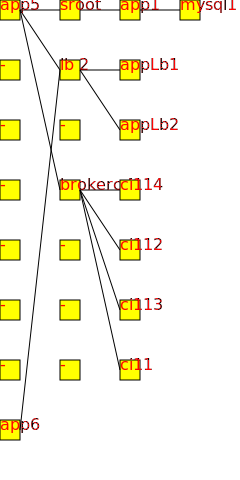

In [2411]:
def balance_nodes(step, grid, qtd, GPosStart):
    
    for nl in range(step):
        last = max(grid[nl], key=int)

        for np in range(qtd):
            posy = last + np + 1
            GPosStart.append_dummy((nl, posy))

def col1_greater_col2(start_y, nposy, nstep, GPosStart):
    diff = start_y - nposy
    for i in range(diff):
        posy = nposy + i
        GPosStart.append_dummy((nstep, posy))
        
    return diff
        
def col1_lower_col2(start_y, nposy, step, GPosStart):
    diff = nposy - start_y
    for dumm in range(diff):
        posy = diff+dumm+start_y
        GPosStart.append_dummy((step, posy))
        
    return diff

def grow_node(total, start, step, GPosStart):
    for ps in range(total-1):
        nps = (step, start + (ps+1))
        GPosStart.append_dummy(nps)
        GPosStart.inc_size()
                
class PositionCrawler(object):
    def __init__(self, node, grid):
        self._grid = grid
        self._node = node
        self._step = node.get('weight')
        
class PositionCrawlerPattern(PositionCrawler):
    def __init__(self, node, grid):
        self._options = {
           'max_inter': 30
        }
        
        super().__init__(node, grid)
        
    def empty_x(self, args=None):
        gpos = GPos()
        gpos.set_position((self._default_x(), 0))
        return gpos
    
    def defaults(self, args=None):
        gpos = GPos()
        gpos.set_position((self._default_x(), self._default_y()))
        return gpos
    
    def soft_balance(self, args=[]):
        GPosStart = GPos()
        start_y = self._default_y(self._step)
        def_y = start_y

        nstep = self._step+1
        nposy = self._default_y(nstep)
        
        if start_y > nposy:
            diff = col1_greater_col2(start_y, nposy, nstep, GPosStart)
                
        if start_y < nposy:
            diff = col1_lower_col2(start_y, nposy, self._step, GPosStart)
            def_y = nposy + diff
        
        if self._step > 0:
            balance_nodes(self._step, self._grid, args-1, GPosStart)

        grow_node(args, def_y, self._step, GPosStart)
        GPosStart.set_position((self._default_x(), def_y))
        
        return GPosStart
    
    def _default_y(self, step=None, posy=0):
        found = 0
        if step is None:
            step = self._step
        
        if step not in self._grid:
            return 0
            
        while posy < self._options.get('max_inter'):
            if (posy not in self._grid[step]):
                found = posy
                break

            posy += 1

        return found
    
    def _default_x(self):
        return self._step

class PositionCrawlerRules(PositionCrawler):
    def __init__(self, node, grid, G, hist):
        super().__init__(node, grid)
        self._hist = hist
        self._graph = G
        
    def map(self):
        return ['soft_balance', 'empty_x', 'defaults']
    
    def find_rule(self):
        for check in self.map():
            checked, args = getattr(self, check)()
            if checked:
                return check, args
    
    def soft_balance(self):
        succers = self._graph[self._node['label']]
        return len(succers) >= 2, len(succers)
        
    def empty_x(self):
        return self._step not in self._grid, None
    
    def defaults(self):
        return True, None
        
    
class PositionFinder(object):
    def __init__(self, G, gridhist=GraphHistogram):
        
        self._grid = {}
        self._graph = G
        
        GridHistogram = gridhist(G)
        self._nmax = GridHistogram.max_value()
        self._hist = GridHistogram.get_counter()

    def set_grid(self, grid):
        self._grid = grid

    def give_pos(self, node, CPattern=PositionCrawlerPattern, CRules=PositionCrawlerRules):
        Patterns = CPattern(node, self._grid)
        Rules = CRules(node, self._grid, self._graph, self._hist)
        
        rule, args = Rules.find_rule()
        pos = getattr(Patterns, rule)(args)
        
        return pos

    
    
print("-------------------------")
Orchestration = GridOrchestrator(G)
Orchestration.create(entries)

Layout = DrawLayout(Orchestration.get_grid())
Layout.draw_nodes()
Layout.draw_connections(G.edges())
Layout.save()

print(Orchestration.get_grid().get_grid())
print(Orchestration.get_grid().index)
   
display(SVG(filename='test.svg'))